<a href="https://colab.research.google.com/github/Aboeleneen/Quora-Question-Pair/blob/master/Quora_Question_pair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Package 

In [ ]:
import numpy as np
import pandas as pd
import nltk # natural language toolkit
from bs4 import BeautifulSoup  # To remove html tags
from nltk.tokenize import word_tokenize # To split a sentence into separate tokens.
from nltk.corpus import stopwords # i , he , she , ....
from nltk.stem import WordNetLemmatizer # Generate the root form of the inflected words

import string 

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_path = '/content/drive/My Drive/Quora_Question_pair/unzipped_dataset/'

In [ ]:
train_data = pd.read_csv(root_path + 'train_orig/train.csv')

In [ ]:
test_data = pd.read_csv(root_path + 'test.csv')

## Explore Data


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


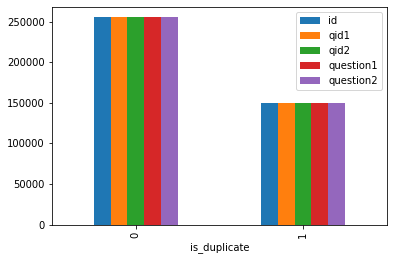

In [ ]:
train_data.groupby("is_duplicate").count().plot.bar()

## Data preprocessing


### Clean the data

In [ ]:
# Drop unneccessary columns from training data
train_data.drop(['id','qid1','qid2'] , axis=1 , inplace=True)
train_data = train_data[~train_data['is_duplicate'].isnull()]

# Helper Functions
def remove_html(text):
  soup = BeautifulSoup(text,'lxml')
  text_html_free = soup.get_text()
  return text_html_free

def remove_punctuation(text):
  no_punct = "".join([c for c in text if c not in string.punctuation])
  return no_punct

def column_preprocess(text):
  text = remove_html(text)
  text = remove_punctuation(text)
  return text

def remove_stopwords(text):
  text = [w for w in text if w not in stopwords.words('english')]
  return text 

def word_lemmatizer(text):
  lemmatizer = WordNetLemmatizer()
  lem_text = [lemmatizer.lemmatize(i) for i in text]
  return lem_text

def preprocess_data(input_data):
  # Remove the rows were one values is missing
  input_data = input_data[~input_data['question1'].isnull()]
  input_data = input_data[~input_data['question2'].isnull()]
  
  # Clean the text columns
  input_data['question1'] = input_data['question1'].apply(lambda x:column_preprocess(x))
  input_data['question2'] = input_data['question2'].apply(lambda x:column_preprocess(x))

  # Tokenize
  input_data['question1'] = input_data['question1'].apply(lambda x:word_tokenize(x.lower()))
  input_data['question2'] = input_data['question2'].apply(lambda x:word_tokenize(x.lower()))

  # Remove stopwords
  input_data['question1'] = input_data['question1'].apply(lambda x:remove_stopwords(x))
  input_data['question2'] = input_data['question2'].apply(lambda x:remove_stopwords(x))

  # Lemmatizing --> maps common words into one base
  input_data['question1'] = input_data['question1'].apply(lambda x:word_lemmatizer(x))
  input_data['question2'] = input_data['question2'].apply(lambda x:word_lemmatizer(x))
  
  return input_data

In [ ]:
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [ ]:
# Save progress
print('Saving progress...')
train_data.to_csv(root_path + 'train_pre.csv', index=False)
test_data.to_csv(root_path + 'test_pre.csv', index=False)
print("saved.")

In [ ]:
# Create lookup table

## Get all unique words
counts = Counter()
train_data['question1'].apply(counts.update);
train_data['question2'].apply(counts.update);
test_data['question1'].apply(counts.update)
test_data['question2'].apply(counts.update)
vocab = sorted(counts , key=counts.get , reverse=True)
vocab_to_int = {word : index for index,word in enumerate(vocab,1)}
int_to_vocab={index:word for index,word in enumerate(vocab,1)}
int_to_vocab

### Embedding Matrix


In [ ]:
###### الحته دى مش فاهمها اوى لو حد يدور عليها يا ريت :)
from gensim.test.utils import datapath
from gensim.models import KeyedVectors

EMBEDDING_FILE = datapath("euclidean_vectors.bin")
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
########

embedding_dim = 300
vocab_size = len(vocab)
embedding_matrix = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)
embedding_matrix[0]= 0 // unknown token

for index,word in enumerate(vocab,1):
  if word in word2vec.vocab:
        try:
            embedding_matrix[index] = word2vec.word_vec(word)
        except:
            pass


### padding

In [ ]:
max_len = 0
for sentence in train_data['question1'] :
  max_len = max(max_len , len(sentence))
for sentence in train_data['question2'] :
  max_len = max(max_len , len(sentence)) 
for sentence in test_data['question1'] :
  max_len = max(max_len , len(sentence))
for sentence in test_data['question2'] :
  max_len = max(max_len , len(sentence)) 

In [ ]:
def integer_encoding_padding(sentence):
  encoding_sentence = [] 
  for word in sentence :
    encoding_sentence.append(vocab_to_int(word))
  while len(encoding_sentence) < max_len :
    enconding_sentence.append(0)
  return encoding_sentence

train_data['question1'].apply(lambda x:integer_encoding_padding(x))
train_data['question2'].apply(lambda x:integer_encoding_padding(x))
test_data['question1'].apply(lambda x:integer_encoding_padding(x))
test_data['question2'].apply(lambda x:integer_encoding_padding(x))
print(max_len)
print(train_data)

### One Hot Encoding


In [ ]:
# there is a built in function in keras for one hot encoding

vocab_size = len(vocab)
def one_hot_encoding(sentence):
  one_hot_encoded_sentence = list()
  for index in sentence :
    encoded_word = np.zeros(vocab_size+1)
    if word != 0 :
      encoded_word[index] = 1
    one_hot_encoded_sentence.append(encoded_word)

train_data['question1'].apply(lambda x:one_hot_encoding(x))
train_data['question2'].apply(lambda x:one_hot_encoding(x))
test_data['question1'].apply(lambda x:one_hot_encoding(x))
test_data['question2'].apply(lambda x:one_hot_encoding(x))
train_data['question1'][0]

KeyboardInterrupt: ignored

## Data preparation

In [ ]:
from sklearn.model_selection import train_test_split
valid_size = 40000
train_size = len(train_data)- valid_size

question_cols = ['question1' , 'question2']
X = train_data[question_cols]
Y = train_data['is_dublicate']

X_train , X_valid , Y_train , Y_valid = train_test_split(X , Y , test_size=train_size)

X_train = {'left' : X_train.question1 , 'right':X_train.question2}
X_valid = {'left' : X_valid.question1 , 'right' : X_valid.question2}
X_test = {'left' : X_test.question1 , 'right' : X_test.question2}

# convert ouput to numpy
Y_train = Y_train.values
Y_valid= Y_valid.values

## Model Arctitecture
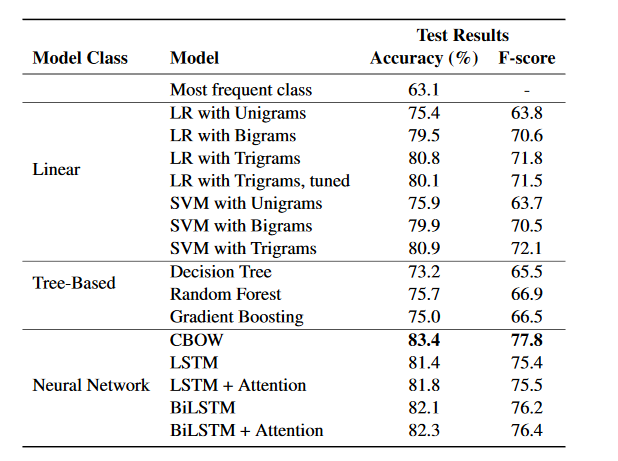

In [ ]:
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Merge ,Concatenate , Dense

# input -> embedding -> LSTM -> concatante -> Dense
def model(input , hidden_units):
  # input shape
  Left_input = Input(shape=(max_len,))
  Right_input = Input(shape=(max_len,))

  # embedding step
  embedding_layer = Embedding(vocab_size , embedding_dim, weights=[embedding_matrix] , input_length=max_len , trainable=False)
  Left_embedding = embedding_layer(Left_input)
  Right_embedding = embedding_layer(Right_input)

  # LSTM step
  shared = LSTM(units=hidden_units , return_sequences=False)
  Left_LSTM = shared(Left_embedding)
  Right_LSTM = shared(Right_embedding)
  
  # Concatenate step
  output = Concatenate(axis=1)([Left_LSTM , Right_LSTM])

  # Fully Connected layer
  Dense1 = Dense(units=50 , activation='relu')
  output = Dense1(output)

  Dense2 = Dense(units=25 , activation='relu')
  output = Dense2(output)

  Dense3 = Dense(units=1 , activation='sigmoid')
  output = Dense3(output)

  # Create model instance
  model = Model(inputs=[Left_input , Right_input], outputs=output)
  return model
